In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys
sys.path.append('..')
import functools

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq_torch

In [83]:
dim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

In [84]:
xdata = (2*(sobol_seq.i4_sobol_generate(2,20)-0.5)) #[-1,1] cube
ydata = exponential_quartic(xdata)
xdata_ = torch.tensor(xdata,dtype=torch.float32)

In [85]:
gp = bvbq_torch.gp.SimpleGP(2,kind='sqe',noise=1e-2)
gp.set_data(xdata,ydata)
gp.mean = -10.0
gp.fix_mean()
gp.fix_noise()
gp.optimize_params()

{'raw_theta': tensor(47.4353), 'raw_lengthscale': tensor(1.4423)}

If tensor has more than 2 dimensions, only diagonal of covariance is returned
torch.Size([2500, 2])


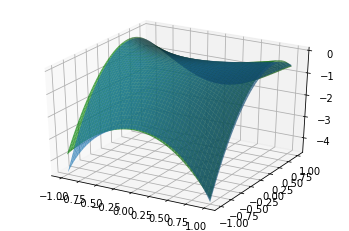

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

Zreg = gp.predict(np.stack([X,Y],axis=-1),istensor=False)[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')